# Visualizing Overfitting and Model Complexity

## Preamble

First we import all the necassary modules.

In [1]:
%load_ext autoreload
%autoreload 2

# Set environment variables because cvxopt might hang otherwise
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

# import courselib utils
from AppliedML.courselib.utils.metrics import accuracy, mean_squared_error
from AppliedML.courselib.utils.preprocessing import labels_encoding
from AppliedML.courselib.utils.splits import train_test_split
from AppliedML.courselib.optimizers import GDOptimizer

# import synthetic data generators
import datagen.ConcentricBands as cc
import datagen.HalfMoons as hm
import datagen.Spirals as sp
import datagen.SeparatedBlobs as sb
import datagen.Postprocessors as pp

# import models
from models.TunableModel import TunableModel
from models.TunableNN import TunableNN
from models.TunableKernelSVM import TunableKernelSVM
from models.TunableRandomForest import TunableRandomForest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from dataclasses import dataclass
from typing import Union
import copy
import itertools

The function `train_tunable_model` is used for training the models, computing the final accuracy for training and test data:

In [2]:
@dataclass
class ExperimentConfig:
    tunable_model: TunableModel
    train_df: pd.DataFrame
    test_df: pd.DataFrame
    training_params: Union[dict, callable]
    encode_label: callable
    measure_accuracy: callable
    random_seed: int
    show_metrics_history: bool = False

def train_tunable_model(cf):
    np.random.seed(cf.random_seed)

    # train models
    models = cf.tunable_model.fit(
        X = cf.train_df[['x', 'y']].to_numpy(),
        y = cf.encode_label(cf.train_df['label']),
        training_params = cf.training_params,
    )

    models = [{"i": i, "model": model, "params": params, "metrics_hist": metrics_hist} 
              for i, model, params, metrics_hist in models]
    models.sort(key=lambda model: model["i"])

    # generate final accuracies
    for model in models:
        model["acc_train"] = cf.measure_accuracy(model["model"], cf.train_df)
        model["acc_test"] = cf.measure_accuracy(model["model"], cf.test_df)
    return models

We use the function `plot_metrics_history` to visualize the training process and `plot_decision` to visualize the result. `plot_model` combines them, but only executes `plot_metrics_history` if corresponding data is available.

In [151]:
def plot_metrics_history(models, title_generator, size=4):
    fig, axs = plt.subplots(1, len(models), figsize=(size*len(models), size))
    if len(models) == 1:
        axs = np.array([axs])
        
    for ax, model in zip(axs.flat, models):
        ax.set_title(title_generator(model["params"]))

        metrics_hist = model["metrics_hist"]
        if metrics_hist is None:
            ax.text(0.5, 0.5, "No metrics available", horizontalalignment='center', verticalalignment='center')
            continue
        
        xs = range(len(metrics_hist['accuracy']))
        acc = metrics_hist['accuracy']
        loss = metrics_hist['loss']

        acc_plt = ax.plot(xs, acc, color='orange', label='Accuracy')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        
        ax2 = ax.twinx()
        loss_plt = ax2.plot(xs, loss, color='blue', label='Loss')
        ax2.set_ylabel('Loss')
        
        plots = acc_plt + loss_plt
        labels = [p.get_label() for p in plots]
        ax.legend(plots, labels, loc='best')
    plt.tight_layout()
    plt.show()

def plot_decision(trained_models, train_df, test_df, title_generator, size=4):
    fig, axs = plt.subplots(1, len(trained_models), figsize=(size*len(trained_models), size))
    if len(trained_models) == 1:
        axs = np.array([axs])
        
    df = pd.concat([train_df, test_df])
    
    x_min, x_max = df['x'].min() - 0.2, df['x'].max() + 0.2
    y_min, y_max = df['y'].min() - 0.2, df['y'].max() + 0.2
    
    x_list, y_list = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    X_list = np.dstack([x_list, y_list])
    
    cmap = matplotlib.colors.ListedColormap(['red', 'blue', 'green'])
    colors = df['label'].astype("category").cat.codes
    
    num_train_samples = len(train_df)
    colors_train = colors[:num_train_samples]
    colors_test = colors[num_train_samples:]
    
    for ax, trained_model in zip(axs.flat, trained_models):
        ax.set_title(title_generator(trained_model["params"]))
        ax.set(aspect="equal")  

        model = trained_model["model"]
        h_list = model(X_list)
        
        ax.text(0.5, -0.1, f"Final train accuracy: {trained_model['acc_train']:.1f}%\n"
                           f"Test accuracy: {trained_model['acc_test']:.1f}%", 
                transform=ax.transAxes, ha='center', va='top', fontsize=12)
    
        ax.contourf(x_list, y_list, h_list, cmap=cmap, alpha=0.3)
        
        ax.scatter(test_df['x'], test_df['y'], c=colors_test, edgecolor='k', alpha=0.6, s=5)
        ax.scatter(train_df['x'], train_df['y'], c=colors_train, edgecolor='k', s=25)
        
    plt.tight_layout()
    plt.show()

def plot_model(trained_models, train_df, test_df, title_generator, size=4):
    has_metrics = len([model["metrics_hist"] for model in trained_models if model["metrics_hist"] is not None]) > 0
    if has_metrics:
        plot_metrics_history(trained_models, title_generator, size)
    plot_decision(trained_models, train_df, test_df, title_generator, size)

To visualize our synthetic data we use `plot_gen`:

In [152]:
def plot_gens(gens, labels, size=4):    
    fig, axs = plt.subplots(1, len(gens), figsize=(size*len(gens), size))
    axs = axs if len(gens) != 1 else np.array([axs])

    for ax, gen, label in zip(axs.flat, gens, labels):
        df = gen.sample_using_seed(num_samples=200, seed=1)
        colors = df['label'].astype("category").cat.codes
        ax.scatter(df['x'], df['y'], c=colors, edgecolor='k', s=25)   
        
        ax.set_title(label)
        ax.set_xlim(-1,1)
        ax.set_ylim(-1,1)

    plt.tight_layout()
    plt.show()

## Creating Synthetic data

In this section we create the synthetic data we will use in the following sections to show under- and overfitting on the different models. We define spirals, half moons, concentric bands and gaussian clusters with and without added noise.
We have different options for noise with classes from datagen.Postprocessors but we mostly use `LabelSwitch`, which just switches the labels of some points for the label of another category.

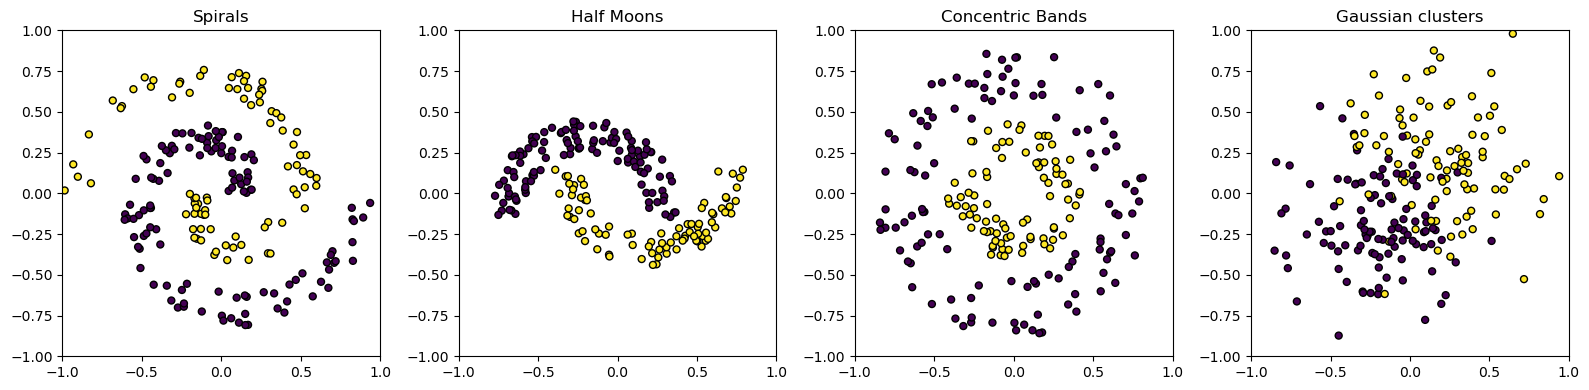

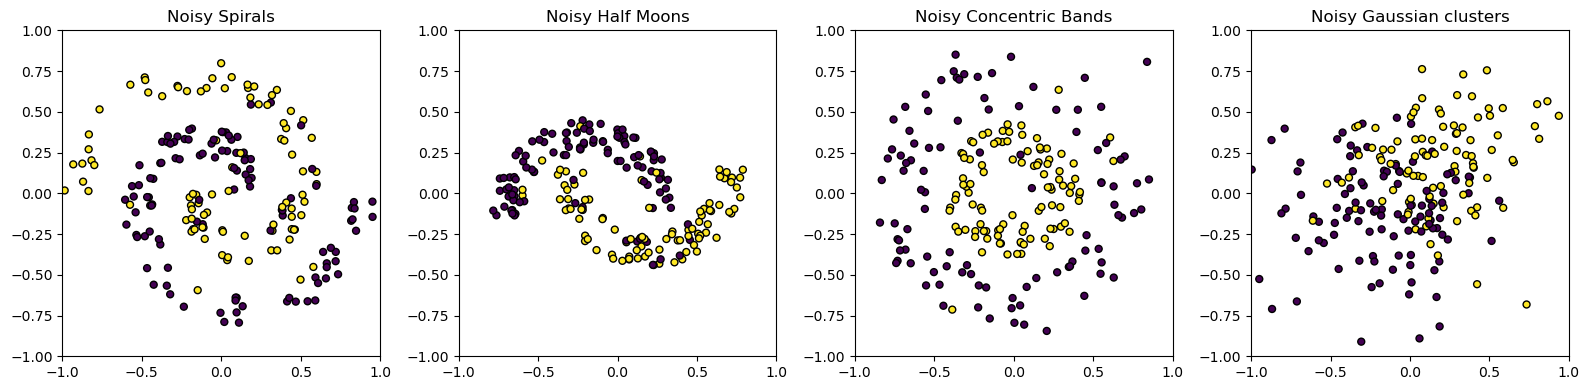

In [242]:
np.random.seed(1)
spirals = sp.Spirals(sp.SpiralConf(2, 0.2, 0.1, 0.9, 1))
spirals_noisy = copy.deepcopy(spirals)
spirals_noisy.add_postprocessor(pp.LabelSwitch(labels=spirals_noisy.labels.values(), noise_freq=0.1))

half_moons = hm.HalfMoons([hm.HalfMoonConf(centre=(-0.2,-0.15), width=0.2, angle_range=(0,np.pi)),
                           hm.HalfMoonConf(centre=(0.2,0.15), width=0.2,angle_range=(np.pi,np.pi*2))])
half_moons_noisy = copy.deepcopy(half_moons)
#half_moons_noisy.add_postprocessor(pp.LabelNoise(noise_level=0.3, noise_freq=0.1))
half_moons_noisy.add_postprocessor(pp.LabelSwitch(labels=half_moons_noisy.labels.values(), noise_freq=0.1))
conc_bands = cc.ConcentricBands([cc.CBandConf(0.7, 0.35), cc.CBandConf(0.3, 0.25)])
conc_bands_noisy = copy.deepcopy(conc_bands)
conc_bands_noisy.add_postprocessor(pp.LabelNoise(noise_level=0.5, noise_freq=0.1))

np.random.seed(5)
sep_blobs = sb.SeparatedBlobs([sb.SepBlobConf(-0.2, -0.2, 0.3), sb.SepBlobConf(0.2, 0.2, 0.3)])
sep_blobs_noisy = copy.deepcopy(sep_blobs)
sep_blobs_noisy.add_postprocessor(pp.LabelNoise(noise_level=0.5, noise_freq=0.1))

plot_gens([spirals  , half_moons  , conc_bands        , sep_blobs], 
          ["Spirals", "Half Moons", "Concentric Bands", "Gaussian clusters"])
plot_gens([spirals_noisy  , half_moons_noisy  , conc_bands_noisy        , sep_blobs_noisy], 
          ["Noisy Spirals", "Noisy Half Moons", "Noisy Concentric Bands", "Noisy Gaussian clusters"])

## Perceptrons

In this section we will look at neural networks using the ReLU activation function. We investigate depth and width of the hidden layers as our complexity parameters. We start by defining a specialized training function:

In [213]:
def trainNN(hyperparameters, test_df, train_df, num_epochs, num_batches, random_seed, show_metrics_history=True):
    tunable_model = TunableNN(hyperparameters=hyperparameters, random_seed=random_seed)
    
    training_params = {
        'num_epochs': num_epochs,
        'batch_size': (len(train_df)) // num_batches,
        'compute_metrics': True,
        'metrics_dict': {'accuracy': accuracy, 'loss': mean_squared_error}
    }

    encode_label = lambda ls: labels_encoding(ls.to_numpy())
    
    measure_accuracy = lambda model, data: \
        accuracy(
            model.decision_function(data[['x', 'y']].to_numpy()), 
            encode_label(data['label'])
        )
        
    configNN = ExperimentConfig(
        tunable_model=tunable_model,
        train_df=train_df,
        test_df=test_df,
        training_params=training_params,
        encode_label=encode_label,
        measure_accuracy=measure_accuracy,
        random_seed=random_seed,
        show_metrics_history=show_metrics_history
    )
    
    return train_tunable_model(configNN)

Next we train a NN on 200 points from the noisy half moons data set. There is overfitting behaviour even without noise, but it is much clearer with added noise. As stated before we are using ReLU with one-hot encoding. Since we are working on a 2D-plane and with only 2 categories, the first and last layer both have 2 neurons. We first use the depth as our complexity parameter and use 10 neurons for each hidden layer. E.g. the model of the graph „Hidden layers: 2“ has the shape 2→10→10→2.

In [172]:
train_split = 0.2
df, train_df, test_df = train_test_split(
    half_moons_noisy.sample_using_seed(num_samples=500, seed=1),
    training_data_fraction=train_split,
    return_numpy=False,
    shuffle=False
)

params = {
    'widths': list(map(lambda x: (2,)+(30,)*x+(2,), [0,2,8,16]))[::-1],
    'activation': ["ReLU"],
    'optimizer': GDOptimizer(learning_rate=0.3)
}

trained_models = trainNN(params, train_df=train_df, test_df=test_df, num_epochs=8000, num_batches = 1, random_seed=1)

Fitting 4 models with 4 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done



We can now plot the results:

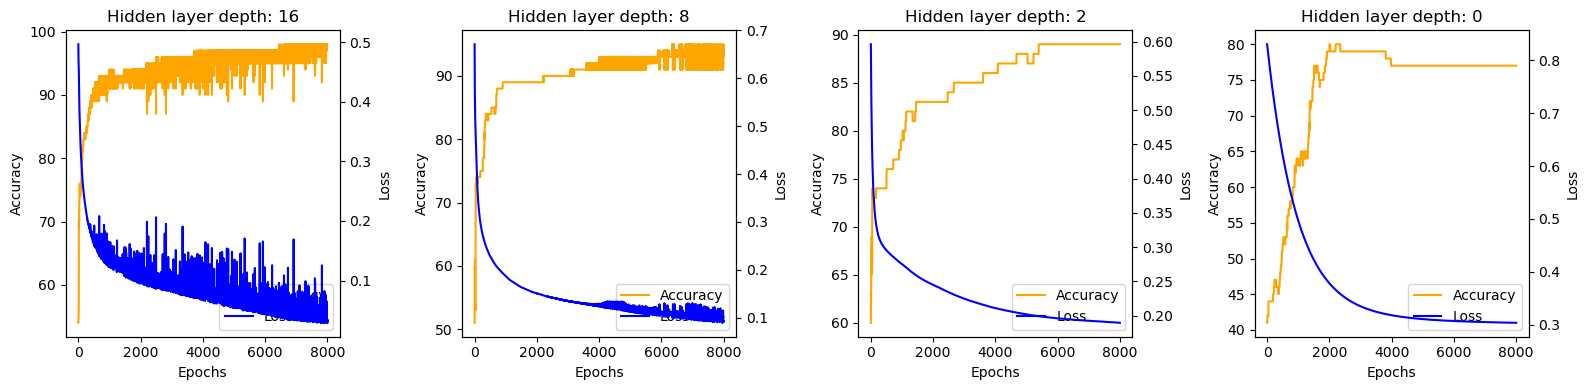

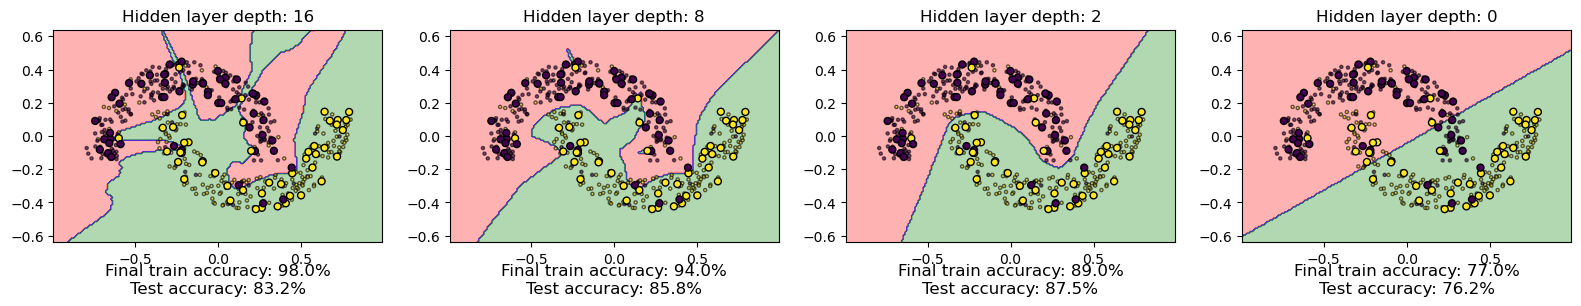

In [173]:
title_generatorNN = lambda params: f"Hidden layer depth: {len(params['widths'])-2}"
plot_model(train_df=train_df, test_df=test_df, title_generator=title_generatorNN, trained_models=trained_models)

The bigger dots represent training data, the smaller and lighter ones represent testing data. The differently colored areas represent the decision boundary.

As we can see, there is clear underfitting for 0 hidden layers, since the decision boundary is to restraint to model the half moons accurately. Also we can clearly see some overfitting of the introduced noise for a hidden layer depth of 8 and 16, instead of going for the simple and correct pattern like the model with layer depth 2 the model gets too complex for its own good.

We further investigate layer width as a complexity parameter with models that have just one hidden layer. For the comparison we are using the same data:

In [176]:
params = {
    'widths': list(map(lambda x: (2,int(x*10),2), [0.25,2,8,32]))[::-1],
    'activation': ["ReLU"],
    'optimizer': GDOptimizer(learning_rate=0.5)
}

trained_models = trainNN(params, train_df=train_df, test_df=test_df, num_epochs=8000, num_batches = 1, random_seed=1)

Fitting 4 models with 4 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done



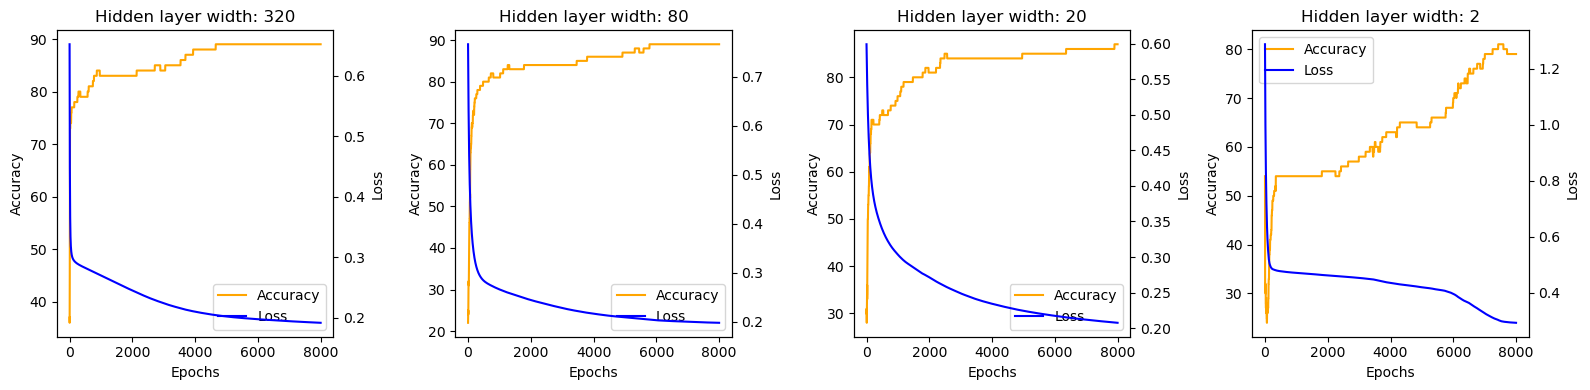

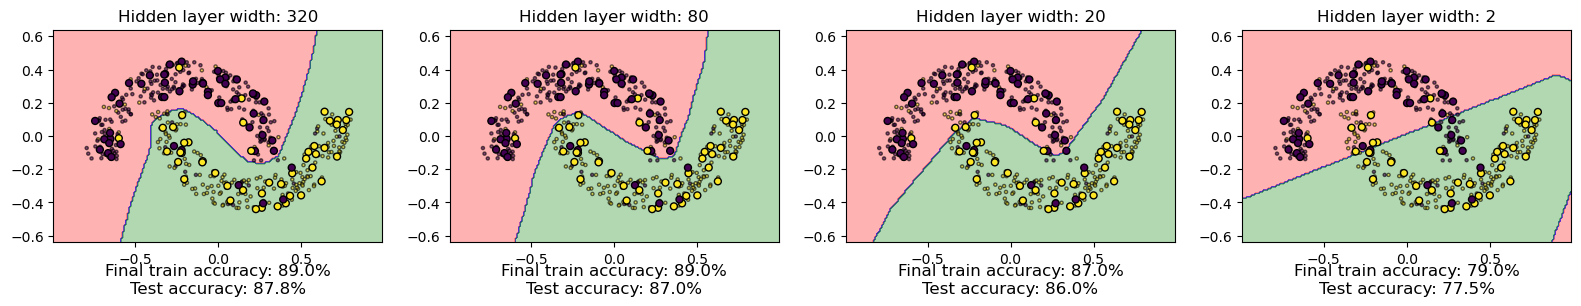

In [177]:
title_generatorNN = lambda params: f"Hidden layer width: {params['widths'][1]}"
plot_model(train_df=train_df, test_df=test_df, title_generator=title_generatorNN, trained_models=trained_models)

While the model is clearly underfitting for only 2 neurons in the hidden layer, we could not find any proper overfitting behaviour like in the case of the depth as a complexity parameter.

## Kernel SVM

In this section we will look at Kernel SVM models using a radial basis function kernel. We focus on sigma as the complexity parameter. 
Again, we start by defining a specialized training function:

In [148]:
def trainKernelSVM(hyperparameters, test_df, train_df, random_seed):    
    tunable_model = TunableKernelSVM(hyperparameters=hyperparameters, random_seed=random_seed)
    
    encode_label = lambda ls: ls.astype("category").cat.codes.to_numpy() * 2 - 1
    
    measure_accuracy = lambda model, data: \
        accuracy(
            model(data[['x', 'y']].to_numpy()), 
            encode_label(data['label']),
            one_hot_encoded_labels=False
        )
        
    configKernelSVM = ExperimentConfig(
        tunable_model=tunable_model,
        train_df=train_df,
        test_df=test_df,
        training_params=None,
        encode_label=encode_label,
        measure_accuracy=measure_accuracy,
        random_seed=random_seed
    )

    return train_tunable_model(configKernelSVM)

Next we train Kernel SVMs on 100 points from the half moons data set. As stated 
before we are using an RBF kernel with quite small to rather large sigma values.

In [251]:
params = {
    'kernel': ['rbf'],
    'sigma': [0.02,0.1,0.25,1],
    'degree': range(1),
    'intercept': range(1),
}
    
train_split = 0.2
df, train_df, test_df = train_test_split(
    spirals.sample_using_seed(num_samples=500, seed=1),
    training_data_fraction=train_split,
    return_numpy=False,
    shuffle=False
)

trained_models = trainKernelSVM(params, test_df=test_df, train_df=train_df, random_seed=5)

Fitting 4 models with 4 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done



We plot the results:

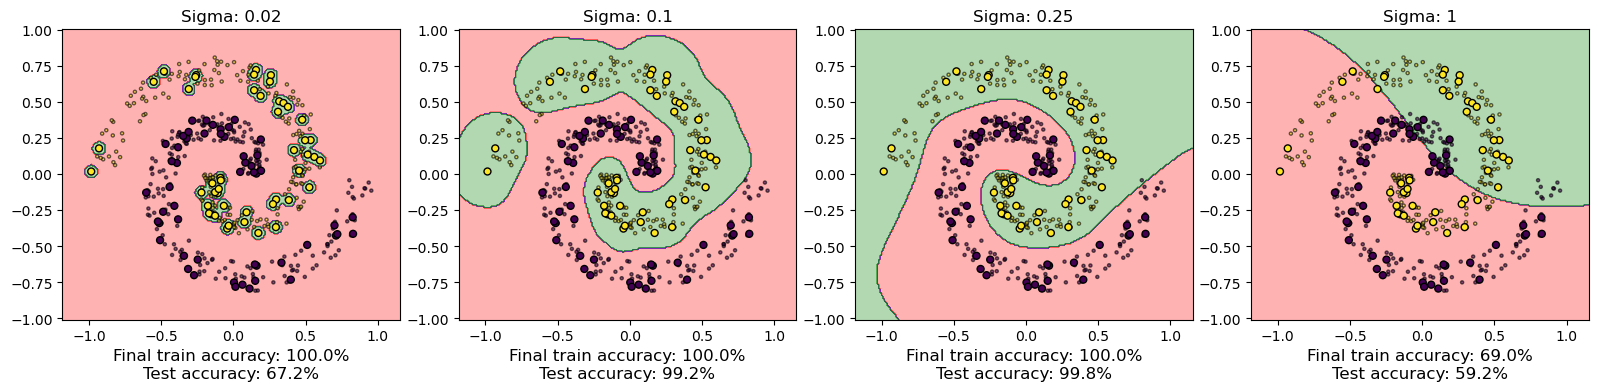

In [252]:
title_generatorKernelSVM = lambda params: f"Sigma: {params['sigma']}"
plot_model(train_df=train_df, test_df=test_df, title_generator=title_generatorKernelSVM, trained_models=trained_models)

As we can see a smaller sigma value clearly reduces underfitting and allows the model to accurately fit the training data. On the other hand, a smaller sigma value allows to modle the given training set too closely, since the decision boundary is getting fitted to circles around (in this case) the points of the second category.

## Decision Trees

In this section we will look at Decision Tree Ensembles. We will look at depth and the number of estimators as the corresponding complexity parameters.
Yet again, we start by defining a specialized training function:

In [194]:
def trainForest(hyperparameters, test_df, train_df, random_seed):    
    tunable_model = TunableRandomForest(hyperparameters=hyperparameters, random_seed=random_seed)
    
    encode_label = lambda ls: ls.to_numpy()
    
    measure_accuracy = lambda model, data: \
        accuracy(
            model.decision_function(data[['x', 'y']].to_numpy()),
            encode_label(data['label']),
            one_hot_encoded_labels=False
        )
        
    configTrees = ExperimentConfig(
        tunable_model=tunable_model,
        train_df=train_df,
        test_df=test_df,
        training_params=None,
        encode_label=encode_label,
        measure_accuracy=measure_accuracy,
        random_seed=1
    )

    return train_tunable_model(configTrees)

Next we train the decision tree ensembles on 200 points from the noisy spirals data set. Here we are testing the model's behaviour regarding a changing depth.

In [249]:
params = {
    'n_estimators': [20],
    'max_depth': [1,8,64,128],
    'min_samples_split': 2,
    'max_features': None
}

train_split = 0.2
df, train_df, test_df = train_test_split(
    spirals_noisy.sample_using_seed(num_samples=1000, seed=1),
    training_data_fraction=train_split,
    return_numpy=False,
    shuffle=False
)

trained_models = trainForest(params, test_df=test_df, train_df=train_df, random_seed=5)

Fitting 4 models with 4 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done



We plot the results:

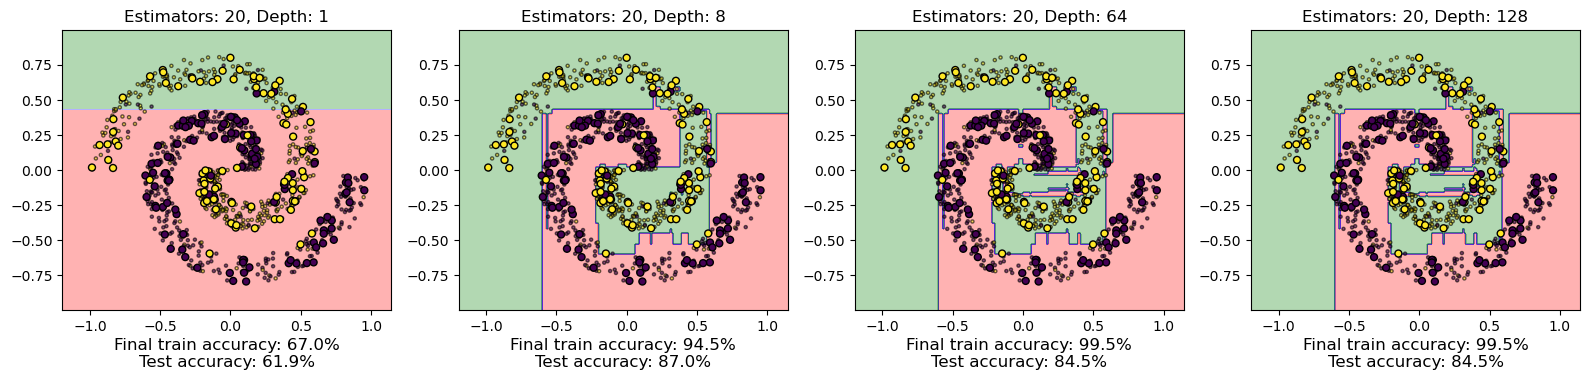

In [250]:
title_generator_forest = lambda params: f"Estimators: {params['n_estimators']}, Depth: {params['max_depth']}"
plot_model(train_df=train_df, test_df=test_df, title_generator=title_generator_forest, trained_models=trained_models)

While it is quite easy to find underfitting (see depth 1) in this case, it has been quite challenging to find proper overfitting using decision tree ensembles. The introduced noise seems to lead to some overfitting (mind the slim pink regions around the middle) here that is also reflected in the test accuracy.

We further investigate the number of estimators as a complexity parameter:

In [247]:
params = {
    'n_estimators': [1,8,64,128],
    'max_depth': [20],
    'min_samples_split': 2,
    'max_features': None
}

train_split = 0.2
df, train_df, test_df = train_test_split(
    spirals_noisy.sample_using_seed(num_samples=1000, seed=1),
    training_data_fraction=train_split,
    return_numpy=False,
    shuffle=False
)

trained_models = trainForest(params, test_df=test_df, train_df=train_df, random_seed=5)

Fitting 4 models with 4 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done



In [ ]:
We plot the results:

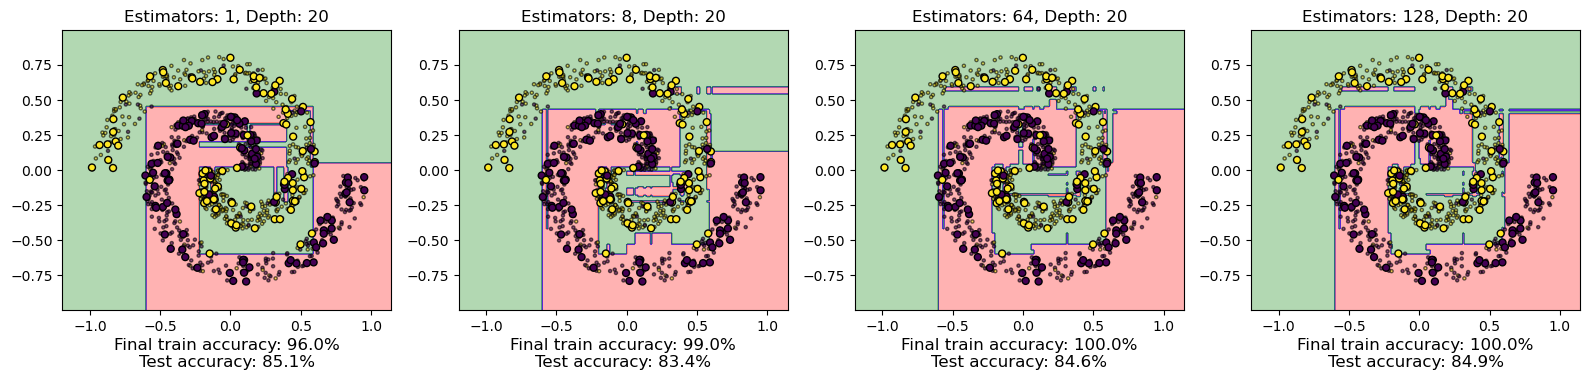

In [248]:
title_generator_forest = lambda params: f"Estimators: {params['n_estimators']}, Depth: {params['max_depth']}"
plot_model(train_df=train_df, test_df=test_df, title_generator=title_generator_forest, trained_models=trained_models)

In this case there is quite clearly neither proper under- nor overfitting to speak of. One might argue that the slim pink regions reflect some overfitting yet again. But

## Final Analysis

We will try to make a quantitative assesement of the bias variance tradeoff. We therefore create and plot the accuracy of our models on a fixed dataset, a fixed complexity range with the class BiasVarianceTradeoff. E.g. we train and plot the accuracy of kernel svms with rbf kernel on a range of complexity 0 to 4, where a complexity of $n$ corresponds to a sigma of $\frac{1}{5^n}$.

In [38]:
class BiasVarianceTradeoff:
    def __init__(self, train_df, test_df, min_cpx, max_cpx, steps_cpx):
        self.train_df = train_df
        self.test_df = test_df
        self.min_cpx = min_cpx
        self.max_cpx = max_cpx
        self.steps_cpx = steps_cpx
    
    def trainNN_with_cpx(self):
        print(f"Training NN")
        complexity_range = np.linspace(self.min_cpx, self.max_cpx, self.steps_cpx["NN"])[::-1]
        params = {
            #'widths': list(map(lambda x: (2,)+(20,)*int(2**x-1)+(2,), complexity_range)),
            'widths': list(map(lambda x: (2,int(2**x),int(2**x),2), complexity_range)),
            'activation': ["ReLU"],
            'optimizer': GDOptimizer(learning_rate=0.3)
        }
    
        return (complexity_range,
                trainNN(params, 
                        train_df=self.train_df,
                        test_df=self.test_df,
                        num_epochs=12000,
                        num_batches=1,
                        random_seed=5,
                        show_metrics_history=False))
    
    def trainKernelSVM_with_cpx(self):
        print(f"Training SVM")
        complexity_range = np.linspace(self.min_cpx, self.max_cpx, self.steps_cpx["SVM"])[::-1]
        params = {
            'kernel': ['rbf'],
            'sigma': list(map(lambda x: (0.2)**x, complexity_range)),
            'degree': range(1),
            'intercept': range(3),
        }
        
        return complexity_range, trainKernelSVM(params, test_df=self.test_df, train_df=self.train_df, random_seed=5)
    
    def trainForest_with_cpx(self):
        print(f"Training Forest")
        complexity_range = np.linspace(self.min_cpx, self.max_cpx, self.steps_cpx["Forest"])[::-1]
        params = {
            'n_estimators': list(map(lambda x: int(4**x), complexity_range)),
            #'max_depth': list(map(lambda x: int(4**x), complexity_range)),
            'max_depth': [20],
            'min_samples_split': 2,
            'max_features': None
        }
        
        return complexity_range, trainForest(params, test_df=self.test_df, train_df=self.train_df, random_seed=5)

    
    def plot_model_accuracy(self, res, ax, model_name):
        complexity_range, trained_models = res
        trained_models.sort(key=lambda x: x["i"])
        #show_tunable_model(train_df=train_df, test_df=test_df, title_generator=title_generatorNN,trained_models=trained_models)
        test_plot = ax.plot(complexity_range,
                           list(map(lambda x: x["acc_test"], trained_models)),
                           label=f"{model_name} Test Acc.")
        color = test_plot[0].get_color()
        ax.plot(complexity_range,
                list(map(lambda x: x["acc_train"], trained_models)),
                linestyle='--',                
                color=color,
                label=f"{model_name} Train Acc.")

    def plot(self):
        fig, ax = plt.subplots()
    
        self.plot_model_accuracy(self.trainNN_with_cpx(), ax=ax, model_name="NN")
        self.plot_model_accuracy(self.trainKernelSVM_with_cpx(), ax=ax, model_name="SVM")
        self.plot_model_accuracy(self.trainForest_with_cpx(), ax=ax, model_name="Forest")
        ax.set_ylabel('Accuracy')
        ax.set_ylim(0,100)
        ax.set_xlabel('Complexity')
        
        plt.title('Bias-variance tradeoff.')
        plt.legend()
        plt.grid()

We now plot the accuracies on the noisy spirals data set:

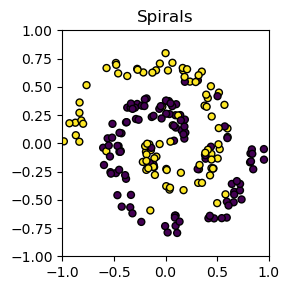

Training NN
Fitting 10 models with 4 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done | Model 6: Done | Model 7: Done | Model 8: Done | Model 9: Done

Training SVM
Fitting 10 models with 4 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done | Model 6: Done | Model 7: Done | Model 8: Done | Model 9: Done

Training Forest
Fitting 10 models with 4 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done | Model 6: Done | Model 7: Done | Model 8: Done | Model 9: Done



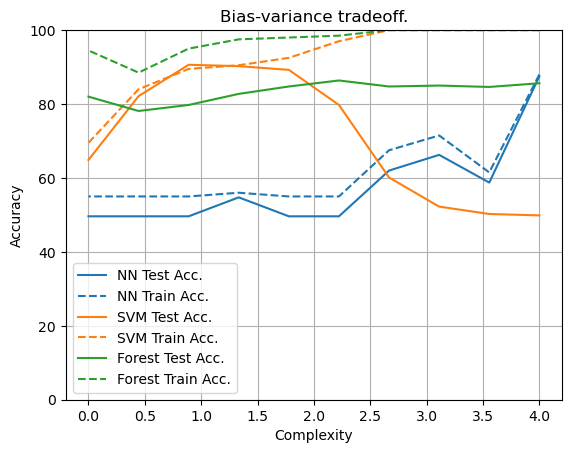

In [39]:
np.random.seed(1)
gen = sp.Spirals(sp.SpiralConf(2, 0.2, 0.1, 0.9, 1))
gen.add_postprocessor(pp.LabelSwitch(labels=list(gen.labels.values()), noise_freq=0.1))
plot_gens([gen], ["Spirals"], size=3)

train_split = 0.2
df, train_df, test_df = train_test_split(
    gen.sample_using_seed(num_samples=1000, seed=1),
    training_data_fraction=train_split,
    return_numpy=False,
    shuffle=False
)

BiasVarianceTradeoff(train_df=train_df, test_df=test_df, min_cpx=0, max_cpx=4, steps_cpx={"NN": 10, "SVM": 10, "Forest": 10}).plot()

Here the dashed lines show the training accuracies, whereas the continuous lines show test accuracy.
Similar to our previous analysis, we can see that there is a clear Bias-variance tradeoff for kernel svms; there is a clear accuracy maximum for a complexity of ca. 1 and a drastic loss in accuracy for lower and higher complexity. In fact the higher complexity models approach a train accuracy of 100% but at the same time a test accuracy of around 50%, so pretty much as bad as it can get.
We don't really see the same thing for decision tree ensembles and neural networks.

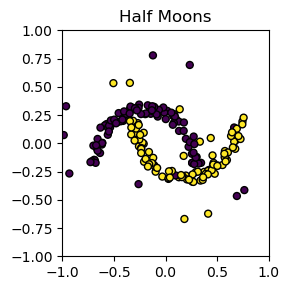

Training NN
Fitting 10 models with 4 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done | Model 6: Done | Model 7: Done | Model 8: Done | Model 9: Done

Training SVM
Fitting 10 models with 4 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done | Model 6: Done | Model 7: Done | Model 8: Done | Model 9: Done

Training Forest
Fitting 10 models with 4 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done | Model 6: Done | Model 7: Done | Model 8: Done | Model 9: Done



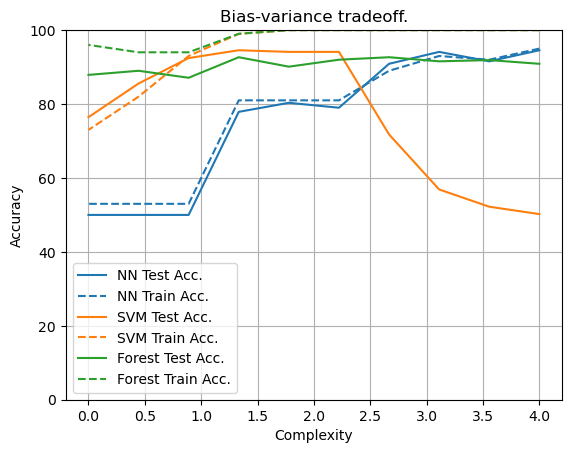

In [17]:
#np.random.seed(1)
#gen = sp.Spirals(sp.SpiralConf(2, 0.25, 0.1, 0.9, 1))
#gen.add_postprocessor(pp.LabelSwitch(labels=list(gen.labels.values()), noise_freq=0.1))
np.random.seed(1)
#gen = sb.RandomSeparatedBlobs()
# gen = hm.HalfMoons([hm.HalfMoonConf(centre=(-0.2,-0.2), width=0.1, angle_range=(0,5.5)),
#                      hm.HalfMoonConf(centre=(0.2,0.2), width=0.1,angle_range=(3.14,3.14+5.5))])

gen = hm.HalfMoons([hm.HalfMoonConf(centre=(-0.2,-0.2), width=0.1, angle_range=(0,3.14)),
                     hm.HalfMoonConf(centre=(0.2,0.2), width=0.1,angle_range=(3.14,6.28))])
#gen = cc.ConcentricBands([cc.CBandConf(0.7, 0.2),cc.CBandConf(0.3,0.2)])
#gen.add_postprocessor(pp.LabelSwitch(labels=list(gen.labels.values()), noise_freq=0.1))
gen.add_postprocessor(pp.LabelNoise(noise_freq=0.1, noise_level=0.5))

plot_gens([gen], ["Half Moons"], size=3)

train_split = 0.1
df, train_df, test_df = train_test_split(
    gen.sample_using_seed(num_samples=1000, seed=1),
    training_data_fraction=train_split,
    return_numpy=False,
    shuffle=False
)

BiasVarianceTradeoff(train_df=train_df, test_df=test_df, min_cpx=0, max_cpx=4, steps_cpx={"NN": 10, "SVM": 10, "Forest": 10}).plot()

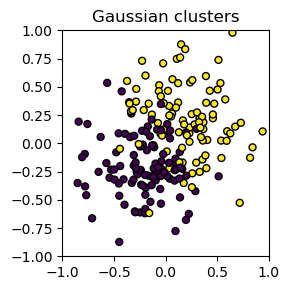

Training NN
Fitting 10 models with 4 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done | Model 6: Done | Model 7: Done | Model 8: Done | Model 9: Done

Training SVM
Fitting 10 models with 4 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done | Model 6: Done | Model 7: Done | Model 8: Done | Model 9: Done

Training Forest
Fitting 10 models with 4 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done | Model 6: Done | Model 7: Done | Model 8: Done | Model 9: Done



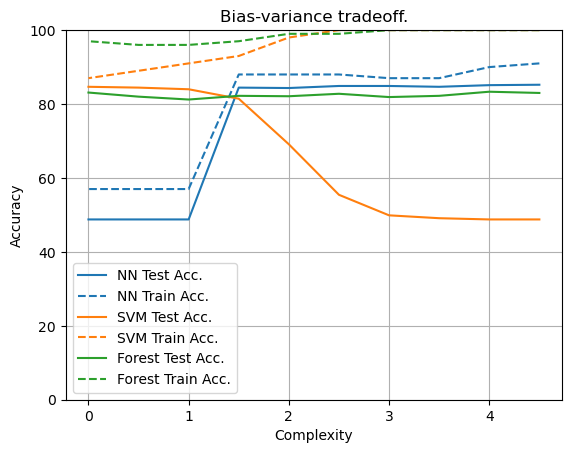

In [18]:
np.random.seed(1)
sep_blobs = sb.SeparatedBlobs([sb.SepBlobConf(-0.2, -0.2, 0.3), sb.SepBlobConf(0.2, 0.2, 0.3)])
plot_gens([sep_blobs], ["Gaussian clusters"], size=3)

train_split = 0.1
df, train_df, test_df = train_test_split(
    sep_blobs.sample_using_seed(num_samples=1000, seed=1),
    training_data_fraction=train_split,
    return_numpy=False,
    shuffle=False
)

BiasVarianceTradeoff(train_df=train_df, test_df=test_df, min_cpx=0, max_cpx=4.5, steps_cpx={"NN": 10, "SVM": 10, "Forest": 10}).plot()